# Раздел 1. Модель

In [1]:
# импорт библиотек

# работа с директориями
from glob import glob # поиск файлов по шаблону
import os
import shutil

# визуализация данных
import matplotlib.pyplot as plt
import pandas as pd

# работа с изображениями
import PIL
from PIL import Image
import torchvision.models as models # модели для работы с изображениями
import torchvision.transforms as transforms # преобразование изображений

# для jupyter notebook
from ipywidgets import FloatProgress
from tqdm.notebook import tqdm # прогресс-бар

# numpy
import numpy as np

# scikit-learn
from sklearn.model_selection import GroupKFold # кросс-валидация
from sklearn.metrics import roc_curve #
from sklearn import metrics #

# pytorch
import torch
import torch.nn as nn # разные слои
import torch.nn.functional as F # функции активации
import torch.nn.init as init # начальная инициализация весов в слоях
from torch.utils.data import Dataset # датасет поместим в объект dataset
from torch.utils.data import DataLoader # это объект разбиения на батчи
from torch.utils.data import random_split
from torchsummary import summary # просмотр архитектуры нейросети

# остальное
import itertools
import random
import time

# комментарии надо дописать

## 1. Постановка задачи

Будем обучать нейросеть, которая должна будет изображения перерисовывать в стиле картин Моне, это задача с kaggle.com - [ссылка](https://www.kaggle.com/competitions/gan-getting-started), данные для обучения скачал оттуда:

- `monet_jpg` - папка с 300 jpg-изображениями картин Моне размера 256x256
- `photo_jpg` - папка с 7038 jpg-изображениями размера 256x256
- `monet_tfrec` и `photo_jpg` - удалил, так как решил работать с .jpg форматом

Использовать для этого будем библиотеку `PyTorch`, поэтому как итог раздела определим на чем будут производиться вычисления - библиотека поддерживает вычисления как на обычном процессоре, так и на графическом.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2. Импорт данных (предварительно упаковав их в интерфейс `Dataset` библиотеки `PyTorch`)

In [3]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256)):
        super().__init__()
        self.monet_dir = monet_dir # это путь к картинам Моне в формате .jpg
        self.photo_dir = photo_dir # это путь к обычным изображениям в том же формате
        self.monet_idx = dict()    # тут будут храниться имена файлов
        self.photo_idx = dict()    # аналогично
        self.transform = transforms.Compose([
            transforms.Resize(size), # приводим к определенному размеру
            transforms.ToTensor(),   # создаем из изображение PyTorch tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # каналы [0, 1] -> [-1, 1]                               
        ])
        # not f.startswith('.') для того чтобы исключить папку .ipynb_checkpoints
        for i, fl in enumerate([f for f in os.listdir(self.monet_dir) if not f.startswith('.')]):
            self.monet_idx[i] = fl
        for i, fl in enumerate([f for f in os.listdir(self.photo_dir) if not f.startswith('.')]):
            self.photo_idx[i] = fl

    def __getitem__(self, idx): # вместе с картиной Моне извлекаем случайное обычное изображение
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return monet_img, photo_img

    def __len__(self):
        return len(self.monet_idx.keys())

In [4]:
img_ds = ImageDataset('monet_jpg/', 'photo_jpg/')

Давайте посмотрим на примеры загруженных данных.

In [5]:
# это обратное преобразование [-1, 1] -> [0, 1] для визуализации (такие данные принимает plt.imshow)
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
    return img

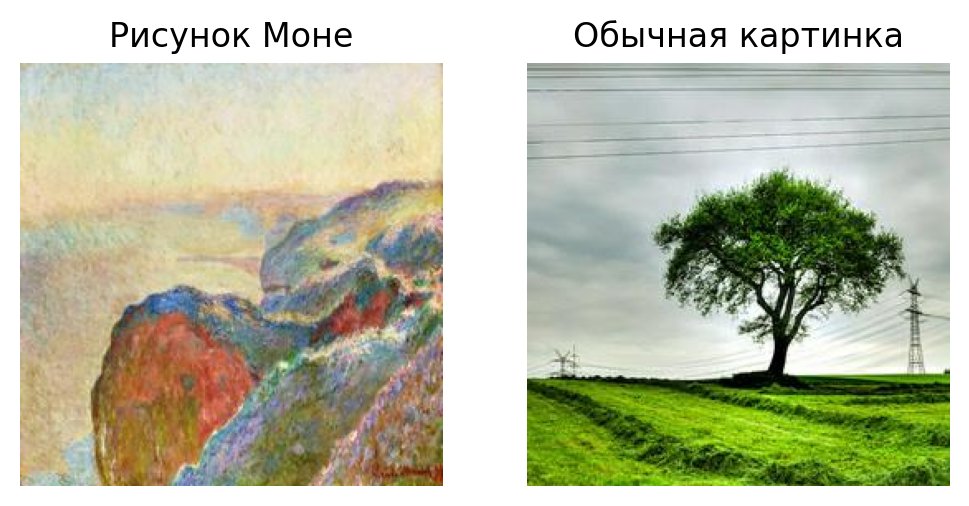

In [6]:
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True) # разбиение на батчи
monet_img, photo_img = next(iter(img_dl)) # извлекаю 1 батч

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), dpi=200)

ax[0].axis('off')
ax[0].set_title('Рисунок Моне')
monet_img = unnorm(monet_img)
ax[0].imshow(monet_img[0].permute(1, 2, 0)) # tensor имеет shape = (channel, width, height)
                                            # переводим его в shape = (width, height, channel) для .imshow
ax[1].axis('off')
ax[1].set_title('Обычная картинка')
photo_img = unnorm(photo_img)
ax[1].imshow(photo_img[0].permute(1, 2, 0));

## 3. Разработка модели

Решение задачи будет осуществляться с помощью нейросети `CycleGAN`.

**CycleGAN** (Cycle-Consistent Generative Adversarial Network) — это тип генеративной состязательной сети (GAN), предназначенный для выполнения непарного перевода изображений. В отличие от традиционных методов, которые требуют пар данных для обучения (например, пары изображений "до" и "после"), CycleGAN обучается на одном наборе изображений для каждой из двух доменов и может генерировать изображения одного домена в изображения другого домена без наличия парных данных.

Архитектура **CycleGAN** состоит из двух основных компонентов: генераторов и дискриминаторов. Она предназначена для выполнения непарного перевода изображений между двумя доменами $ X $ и $ Y $. Основная идея заключается в использовании двух генераторов и двух дискриминаторов, а также добавлении потерь циклической консистентности, чтобы преобразование изображений было обратимым. Рассмотрим архитектуру более подробно.

CycleGAN включает:
- **Два генератора**:
  - $ G_{X \to Y} $: преобразует изображения из домена $ X $ (например, лошади) в домен $ Y $ (например, зебры).
  - $ G_{Y \to X} $: преобразует изображения из домена $ Y $ обратно в домен $ X $.
  
- **Два дискриминатора**:
  - $ D_Y $: различает между реальными изображениями домена $ Y $ и изображениями, сгенерированными $ G_{X \to Y} $.
  - $ D_X $: различает между реальными изображениями домена $ X $ и изображениями, сгенерированными $ G_{Y \to X} $.

### 3.1. Архитектура генератора и дискриминатора

Для генераторов и дискриминаторов будем использовать следующие слои:

- **Слой свертки** `Conv2d`: реализует двумерную свёртку, которая используется для обработки двумерных данных; вот эти параметры будем использовать для задания этого слоя:
    - `in_channels`: количество входных каналов (слой применяет ядро свертки для каждого канала независимо, а затем складывает результаты)
    - `out_channels`: количество независимых ядер свертки, указывает количество выходных каналов;
    - `kernel_size`: размер ядра свертки;
    - `stride`: шаг перемещения ядра свертки;
    - `padding`: определяет надо ли добавлять нули по границам изображения (для сохранения размера выхода);
    - `bias`: добавлять ли обучаемое смещение.
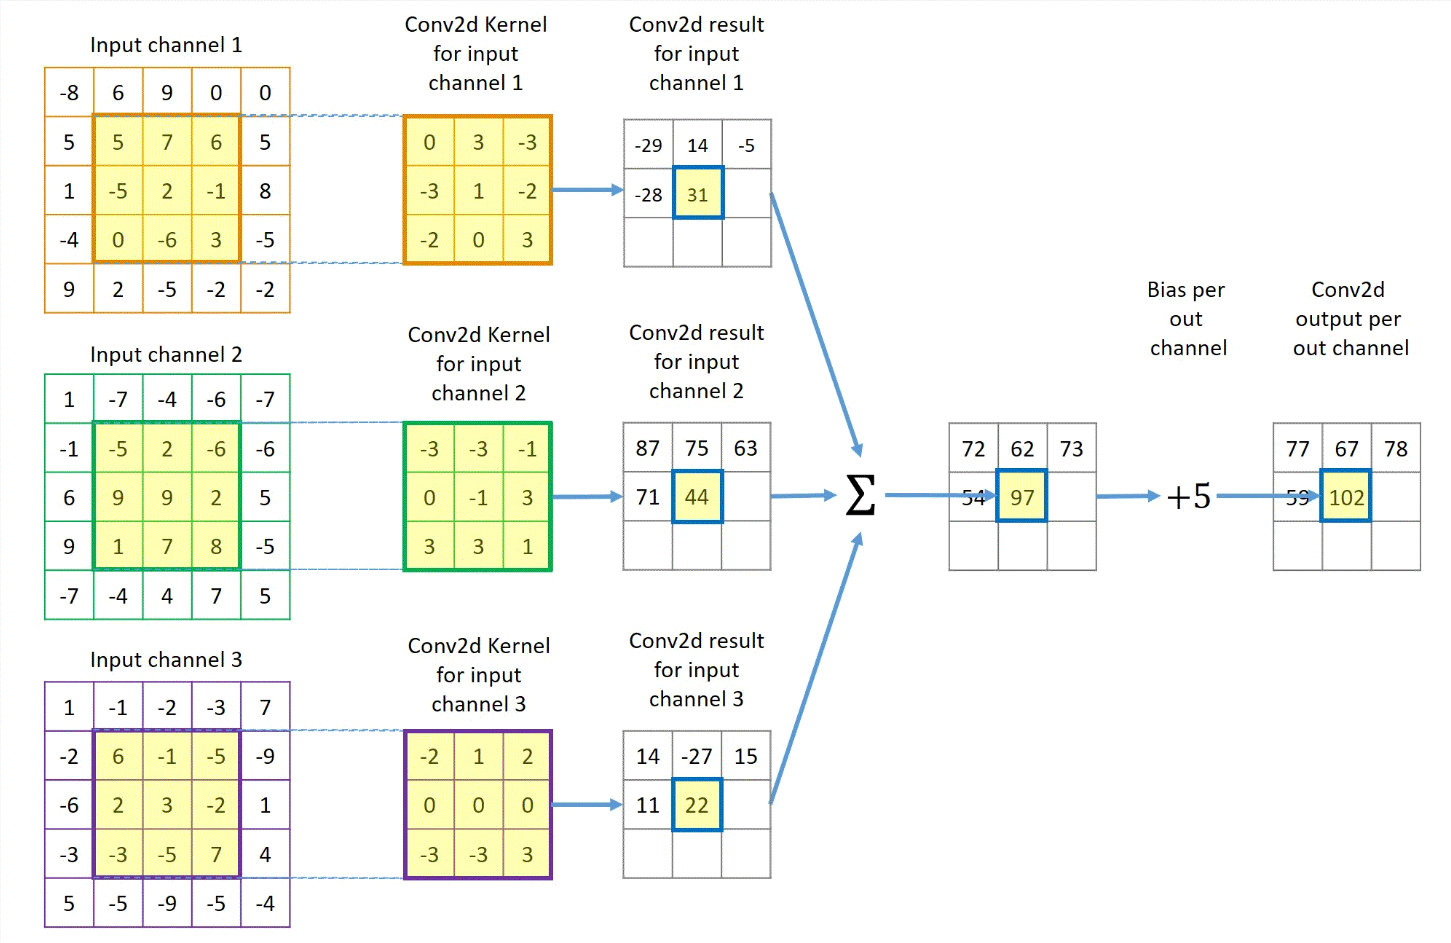
- **Слой обратной свертки** `ConvTranspose2d`: реализует свертку с увеличением размерности:
    - `in_channels`: количество входных каналов
    - `out_channels`: количество независимых ядер свертки, указывает количество выходных каналов;
    - `kernel_size`: размер ядра свертки;
    - `stride`: шаг перемещения ядра свертки;
    - `padding`: определяет сколько нулей добавлять по границам изображения;
    - `output_padding`: более тотечная настройка размера выходного изображения (реализуется тем же путем, что и `padding`).
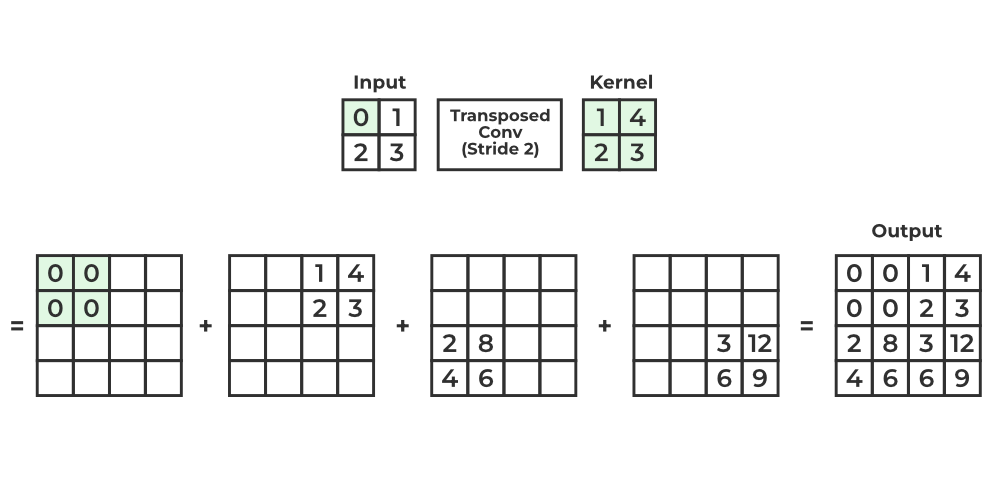
- **Слой дополнения изображения** `ReflectionPad2d` с его помощью на границах тензора зеркально отражаются его значения:
    - `padding`: размеры паддинга `(left, right, top, bottom)`.
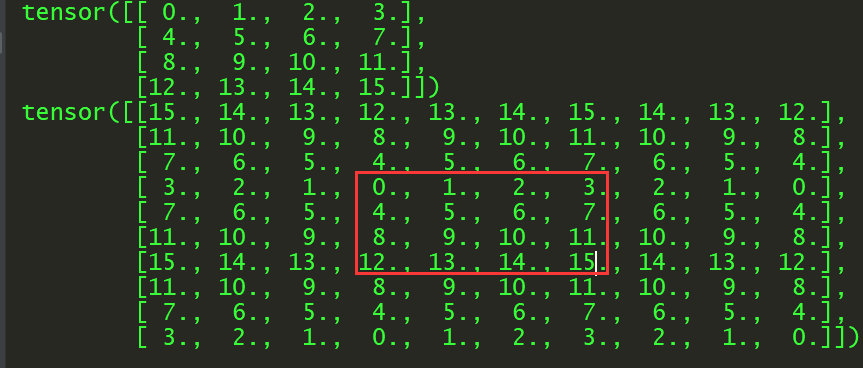
- **Слой деактивации** `Dropout`:
    - *Во время обучения* в каждом шаге обучения случайным образом выбирается подмножество нейронов в слое, которые будут "выключены", это делается с вероятностью `p`, остальные нейроны масштабируются на значение $\dfrac1{1-p}$;
    - *Во время тестирования* слой не работает.
- **Слои нормализации**:
    - `BatchNorm2d`: нормализует каждый признак поотдельности независимо от канала по всему батчу:
        - `num_features`: количество каналов;
        - далее $x_{i, c}$ - $c$-й канал из $i$-го батча ($x_{i, c}\in\mathbb R^{256 \times 256}$), $m$ - размер батча;
        - $\displaystyle \mu_c = \frac{1}{m} \sum\limits_{i=1}^{m} x_{i, c}$ - среднее значение в батче;
        - $\displaystyle \sigma_c^2 = \frac{1}{m} \sum\limits_{i=1}^{m} (x_{i, c} - \mu_c)^2$ - квадрат среднеквадратического отклонения;
        - $\displaystyle \hat{x}_{i, c} = \frac{x_{i, c} - \mu_c}{\sqrt{\sigma_c^2 + \varepsilon}}$ - нормализованное значение, где $\varepsilon$ - просто какое-то маленькое значение;
        - $\displaystyle y_{i, c} = \gamma_c \hat{x}_{i, c} + \beta_c$ - выходное значение, полученное масштабированием и смещением ($\gamma_c$ и $\beta_c$ - обучаемые параметры).
    - `InstanceNorm2d`: нормализует признаки независимо от канала и батча:
        - `num_features`: количество каналов;
        - далее $x_{j, c}^i$ - $j$-й признак $c$-го канала из $i$-го батча, $n$ - размер канала;
        - $\displaystyle \mu_c^i = \frac{1}{n} \sum\limits_{j=1}^{n} x_{j, c}^i$ - среднее значение по каналу в батче;
        - $\displaystyle \sigma_c^{i2} = \frac{1}{n} \sum_{j=1}^{n} (x_{j, c}^i - \mu_c^i)^2$ - квадрат среднеквадратического отклонения;
        - $\displaystyle \hat{x}_{j, c}^i = \frac{x_{j, c}^i - \mu_c^i}{\sqrt{\sigma_c^{i2} + \varepsilon}}$ - нормализованное значение;
        - $\displaystyle y_{j, c}^i = \gamma_c \hat{x}_{j, c}^i + \beta_c$ - масштабирование и смещение (тут аналогично $\gamma_c$ и $\beta_c$ - обучаемые параметры).

А также в генераторах и дискриминаторах будем использовать следующие функции активации (оформленные в слои):

- **Leaky Rectified Linear Unit** `LeakyReLU`

$\operatorname{LeakyReLU}(x) = \left\{\begin{align*}
x,\ x \geq 0, \\
\alpha x,\ x < 0.
\end{align*}\right.$

- **Gaussian Error Linear Unit** `GELU`

$\displaystyle
\operatorname{GELU}(x) = x \cdot \Phi(x) = 0.5x \left(
1+\operatorname{Tanh} \left(
    \sqrt\frac2\pi \left(
        x+0.044715x^3
        \right)
    \right)
\right)$

- **Hyperbolic Tangent** `Tanh`

$\displaystyle
\operatorname{Tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

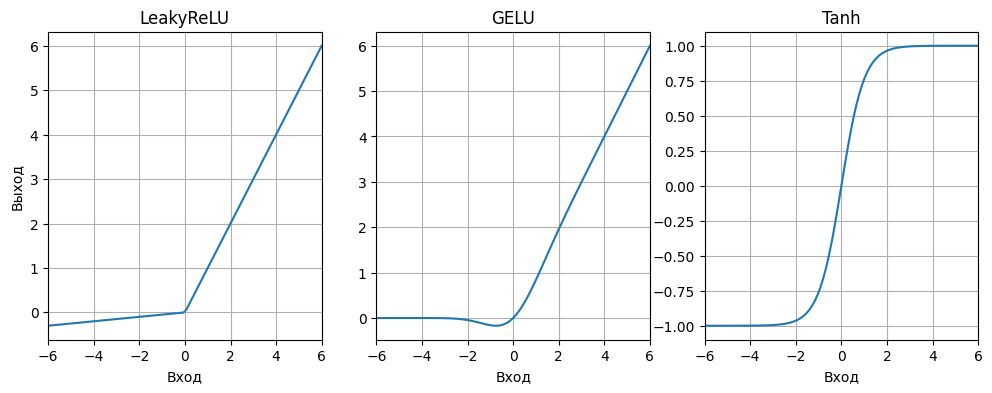

In [7]:
leaky_relu = lambda x: np.where(x > 0, x, 0.05 * x)
gelu = lambda x: 0.5 * x * (1 + tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))
tanh = lambda x: np.tanh(x)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi=100)

x = np.linspace(-6, 6, 100)
for axis, func, name in zip(ax, [leaky_relu, gelu, tanh], ['LeakyReLU', 'GELU', 'Tanh']):
    axis.plot(x, func(x))
    axis.set_xlim(-6, 6)
    axis.set_xticks([i for i in range(-6, 7, 2)])
    axis.set_title(name)
    axis.set_xlabel('Вход')
    axis.grid()
ax[0].set_ylabel('Выход');

Для начала опишем более продвинутые слои для дальнейшей модели:
- Слой деконволюции `Upsample`;
- Слой конволюции `Convlayer`;
- Остаточный блок `Resblock`.

In [8]:
def Upsample(in_ch, out_ch, use_dropout=True, dropout_ratio=0.5):
    if use_dropout:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.Dropout(dropout_ratio),
            nn.GELU()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.GELU()
        )

In [9]:
def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True):
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding=1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding=0, bias=True)

    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)

    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()

    return nn.Sequential(
        conv,
        norm,
        actv
    )

In [10]:
class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Convlayer(in_features, in_features, kernel_size=3, stride=1,
                                use_leaky=False, use_inst_norm=True, use_pad=False))
        layers.append(nn.Dropout(dropout_ratio))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(in_features))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

А теперь строим сами генераторы и дескриминаторы.

In [11]:
class Generator(nn.Module):
    def __init__(self, in_ch, out_ch, num_res_blocks=6):
        super().__init__()
        model = list()
        
        # Напоминаю про параметры Convlayer
        # Convlayer(in_ch, out_ch, kernel_size, stride, use_leaky, use_inst_norm, use_pad)
        
        # 1. Извлечение признаков
        model.append(nn.ReflectionPad2d(3))
        model.append(Convlayer(in_ch, 64, kernel_size=7, stride=1,
                               use_leaky=False, use_pad=False))
        model.append(Convlayer(64, 128, 3, 2, False))
        model.append(Convlayer(128, 256, 3, 2, False))
        
        # 2. Преобразование изображения
        for _ in range(num_res_blocks):
            model.append(Resblock(256))

        # 3. Генерация изображения
        model.append(Upsample(256, 128))
        model.append(Upsample(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)

In [12]:
# пример генератора с одним Resblock
gen_example = Generator(3, 3, 1)
summary(gen_example, input_size=(3, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              GELU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              GELU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             GELU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
             GELU-14          [-1, 256,

In [13]:
class Discriminator(nn.Module):
    def __init__(self, in_ch, num_layers=3):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_ch, 64, kernel_size=4, stride=2, padding=1))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        for i in range(1, num_layers + 1):
            in_chs = 64 * 2**(i-1)
            out_chs = in_chs * 2
            if i == num_layers:
                model.append(Convlayer(in_chs, out_chs, kernel_size=4, stride=1))
            else:
                model.append(Convlayer(in_chs, out_chs, kernel_size=4, stride=2))
        model.append(nn.Conv2d(out_chs, 1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

In [14]:
disc_example = Discriminator(3)
summary(disc_example, input_size=(3, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]               0
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-10          [-1, 512, 31, 31]               0
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
---------------------------

Заметим, что у данных на которых будем обучать модель (изображение 256 на 256 пикселей с 3 каналами) выходом дискриминатора будет тензор размера 30 на 30, потому что это так называемый `PatchGAN`-дискриминатор: вместо того, чтобы давать общий ответ является ли изображение настоящим или фейковым, он дает целую карту вероятностей на каждый участок изображения.

### 3.2. Архитектура CycleGAN

Перед тем как приступить к проектированию самой нейрости, определим несколько функций.

Для начала нам надо инициализировать начальные веса, для этого используем метод из `PyTorch` - `apply`. Инициализировать будем случайно по нормальному распределению (при $\operatorname{mean}=0$, $\operatorname{std}=$`gain`), смещения инициализируем нулем. В нашей задаче этого требуют слои конволюции и нормализации.

In [15]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        # нормализуем веса слоев конволюции
        if hasattr(m, 'weight') and classname.find('Conv') != -1:
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        # нормализуем веса слоев нормализации
        elif classname.find('BatchNorm2d') != -1 and m.weight is not None:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

Цикл обучения `CycleGAN` включает в себя:

#### 1. Обучение генераторов по ошибкам:
- **Cycle Consistency Loss**: Изображение из домена $X$ прогоняется по генератору $G_{X \to Y}$, а затем по генератору $G_{Y \to X}$ и смотрим как хорошо изображение восстановилось, аналогично проделываем с изображением для домена $Y$;
- **Identity Loss**: Изображение из домена $X$ прогоняется в генератор $G_{Y \to X}$ и предполагается, что оно не должно видоизмениться, аналогично для изображения из домена $Y$;
- **Adversarial Loss**: Генератор $G_{X \to Y}$ должен генерировать такие изображения, чтобы дискриминатор не мог отличить их от настоящих изображений из домена $Y$, аналогично для генератора $G_{Y \to X}$.

Остановимся поподробней про **Adversarial Loss** (например для генератора $G_{X \to Y})$:

$L_\text{AdvLoss} = L_\text{AdvLoss}(D_Y(G_{X \to Y}(x)), 1)$, где $1$ имеется ввиду, что изображение настоящее

Заметим, что в таком случае при обратном распространении ошибки пройдем и через дискриминатор, чего бы нам не хотелось (идея в том, что генератор пытается обманывать дискриминатор пока дискриминатор никак в обучении не участвует), поэтому хотелось бы заранее определить функцию, отключающую тренировку весов.

In [16]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

#### 2. Обучение дискриминаторов

Дискриминаторы будут обучаться по настоящим и фековым изображениям из обоих доменов. Чтобы дискриминаторы не переучивались только на текущие паттерны генераторов, создадим буфер, из которого с контролируемой вероятностью (в случае кода ниже с вероятностью $50%$) доставал ранее сгенерированные изображения.

In [17]:
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

А также сделаем класс адаптивной скорости обучения, чтобы при приближении к минимуму потерь случайно его не перешагнуть, для этого первые `decay_epochs` эпох `learning_rate` остается неизменным, а затем постепенно линейно доводим его до 0. Обернули это всё в класс, чтобы функция видела локальные параметры `decay_epochs` и `total_epochs`. 

In [18]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

И еще определим класс, в котором будем хранить сводку по эпохам для генераторов и дискриминаторов.

In [19]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses = []
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

Теперь переходим к самому `CycleGAN`. Поговорим о потерях которые будем далее скалировать.

Функцией потерь для сравнения сгенерированных изображений (для Cycle Consistency Loss и Identity Loss) возьмем `L1Loss`:

$\displaystyle
\operatorname{L1}(x, y) = \frac1N \sum_{i=1}^N |x_i - y_i|
$

А для дискриминаторов будем использовать `BCELoss` (бинарная кросс-энтропия) или `MSELoss` (среднеквадратичное отклонение):

$\displaystyle
\operatorname{BCE}(y, \hat y) = -\hat y\log(y) - (1-\hat y)\log(1-y),
$

где $\hat y$ - истинное значение, $y$ - предсказанное, в нашем случае будет браться средняя ошибка (дискриминаторы выдают целую карту предсказаний).

$\displaystyle
\operatorname{MSE}(x, y) = \frac1N \sum_{i=1}^N (x_i - y_i)^2$

Заметим, что для генераторов используется 3 вычисленные ошибки, поэтому требуется определить вес каждой из ошибок для обучения:

$L = L_\text{adv} + \lambda_\text{cyc} L_\text{cyc} + \lambda_\text{idt} L_\text{idt}$

В коде введем другие обозначения:

$\lambda_\text{cyc} =$ `lmbda`

$\lambda_\text{idt} =$ `lmbda` $*$ `idt_coef`

In [20]:
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        self.gen_mtp = Generator(in_ch, out_ch)
        self.gen_ptm = Generator(in_ch, out_ch)
        self.desc_m = Discriminator(in_ch)
        self.desc_p = Discriminator(in_ch)
        self.init_models() # инициализируем веса (функция определена ниже)
        self.desc_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        # оптимизатор для генераторов, их связываем с весами генераторов
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                         lr=start_lr, betas=(0.5, 0.999))
        # аналогично для дискриминаторов
        self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()),
                                          lr=start_lr, betas=(0.5, 0.999))
        # это буфер для сгенерированных изображений
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        # создаем функции для вычисления learning rate на каждой эпохе через создание классов
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        desc_lr = lr_sched(self.decay_epoch, self.epochs)
        # и связываем их с оптимизаторами
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, desc_lr.step)
        # в этих классах будем хранить параметры эпох чтобы отследить обучение модели
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        
    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.desc_m)
        init_weights(self.desc_p)
        # переводим модели на устройство которое вычислили в начале ноутбука
        # (в идеале вычисления должны быть на cuda-ядрах графического процессора)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.desc_m = self.desc_m.to(self.device)
        self.desc_p = self.desc_p.to(self.device)
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(device), monet_real.to(device)
                
                # выключаем обучение дискриминаторов (описано перед объявлением этой функции)
                update_req_grad([self.desc_m, self.desc_p], False)
                self.adam_gen.zero_grad()

                # генерирование изображений из тренировочных данных
                fake_photo = self.gen_mtp(monet_img)
                fake_monet = self.gen_ptm(photo_img)

                # могут ли генераторы воссоздавать исходные изображения? =>(1)
                cycl_monet = self.gen_ptm(fake_photo)
                cycl_photo = self.gen_mtp(fake_monet)

                # могут ли генераторы сохранять идентичность подаваемых изображений? =>(2)
                id_monet = self.gen_ptm(monet_img)
                id_photo = self.gen_mtp(photo_img)

                # (1) определяем важность потерь
                cycle_loss_monet = self.l1_loss(cycl_monet, monet_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycl_photo, photo_img) * self.lmbda

                # (2) определяем важность потерь
                idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                # адверсариальные потери (то есть насколько хорошо генераторы обманывают дискриминаторы)
                monet_desc = self.desc_m(fake_monet)
                photo_desc = self.desc_p(fake_photo)

                real = torch.ones(monet_desc.size()).to(self.device)

                adv_loss_monet = self.desc_loss(monet_desc, real)
                adv_loss_photo = self.desc_loss(photo_desc, real)

                # общие потери
                total_gen_loss = cycle_loss_monet + adv_loss_monet\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_monet + idt_loss_photo
                # тут просто потери для вывода на экран
                avg_gen_loss += total_gen_loss.item()

                # обучающий шаг генераторов по всем потерям
                total_gen_loss.backward()
                self.adam_gen.step()

                # а теперь приступаем к обучению дискриминаторов
                update_req_grad([self.desc_m, self.desc_p], True)
                self.adam_desc.zero_grad()

                # подгружаем сгенерированные фото
                fake_monet = self.sample_monet([fake_monet.cpu().data.numpy()])[0]
                fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
                fake_monet = torch.tensor(fake_monet).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)

                # и делаем предсказание
                monet_desc_real = self.desc_m(monet_img)
                monet_desc_fake = self.desc_m(fake_monet)
                photo_desc_real = self.desc_p(photo_img)
                photo_desc_fake = self.desc_p(fake_photo)

                real = torch.ones(monet_desc_real.size()).to(self.device)
                fake = torch.zeros(monet_desc_fake.size()).to(self.device)

                # потери
                monet_desc_real_loss = self.desc_loss(monet_desc_real, real)
                monet_desc_fake_loss = self.desc_loss(monet_desc_fake, fake)
                photo_desc_real_loss = self.desc_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.desc_loss(photo_desc_fake, fake)

                # определяем доли для потерь
                monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                # а тут просто потери для вывода на экран  
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # обучающий шаг генераторов
                monet_desc_loss.backward()
                photo_desc_loss.backward()
                self.adam_desc.step()

                # просто обновляем прогресс-бар, не имеет отношение к обучению
                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())

            #torch.save(self.gen_ptm, 'gen.pth')
            
            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_desc_loss))
      
            self.gen_lr_sched.step()
            self.desc_lr_sched.step()

In [21]:
gan = CycleGAN(3, 3, 50, device)

### 3.3. Тренировка модели

In [22]:
# определили img_dl в самом первом разделе по импорту тренировочных данных
gan.train(img_dl)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (1) | Generator Loss:11.125035 | Discriminator Loss:0.844176


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (2) | Generator Loss:9.493942 | Discriminator Loss:0.467938


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (3) | Generator Loss:8.991935 | Discriminator Loss:0.437765


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (4) | Generator Loss:8.391575 | Discriminator Loss:0.428058


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (5) | Generator Loss:8.394876 | Discriminator Loss:0.398859


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (6) | Generator Loss:8.195456 | Discriminator Loss:0.374103


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (7) | Generator Loss:8.146169 | Discriminator Loss:0.404758


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (8) | Generator Loss:7.932926 | Discriminator Loss:0.393626


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (9) | Generator Loss:7.720143 | Discriminator Loss:0.401518


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (10) | Generator Loss:7.545888 | Discriminator Loss:0.395100


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (11) | Generator Loss:7.526350 | Discriminator Loss:0.384341


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (12) | Generator Loss:7.362407 | Discriminator Loss:0.391287


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (13) | Generator Loss:7.395780 | Discriminator Loss:0.391742


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (14) | Generator Loss:7.224369 | Discriminator Loss:0.375473


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (15) | Generator Loss:7.251155 | Discriminator Loss:0.375014


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (16) | Generator Loss:7.352388 | Discriminator Loss:0.368892


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (17) | Generator Loss:7.170487 | Discriminator Loss:0.376454


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (18) | Generator Loss:7.119221 | Discriminator Loss:0.359960


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (19) | Generator Loss:7.130077 | Discriminator Loss:0.332499


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (20) | Generator Loss:7.034092 | Discriminator Loss:0.356122


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (21) | Generator Loss:6.934916 | Discriminator Loss:0.345158


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (22) | Generator Loss:6.964594 | Discriminator Loss:0.349430


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (23) | Generator Loss:6.897734 | Discriminator Loss:0.346168


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (24) | Generator Loss:6.860503 | Discriminator Loss:0.349078


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (25) | Generator Loss:6.739987 | Discriminator Loss:0.349680


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (26) | Generator Loss:6.848528 | Discriminator Loss:0.327024


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (27) | Generator Loss:6.588142 | Discriminator Loss:0.342084


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (28) | Generator Loss:6.839718 | Discriminator Loss:0.306448


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (29) | Generator Loss:6.655110 | Discriminator Loss:0.295752


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (30) | Generator Loss:6.539527 | Discriminator Loss:0.296544


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (31) | Generator Loss:6.558711 | Discriminator Loss:0.284799


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (32) | Generator Loss:6.640106 | Discriminator Loss:0.259742


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (33) | Generator Loss:6.569874 | Discriminator Loss:0.251772


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (34) | Generator Loss:6.434390 | Discriminator Loss:0.245935


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (35) | Generator Loss:6.464222 | Discriminator Loss:0.249347


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (36) | Generator Loss:6.552188 | Discriminator Loss:0.230341


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (37) | Generator Loss:6.464004 | Discriminator Loss:0.229083


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (38) | Generator Loss:6.342012 | Discriminator Loss:0.219318


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (39) | Generator Loss:6.302595 | Discriminator Loss:0.217274


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (40) | Generator Loss:6.281836 | Discriminator Loss:0.192597


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (41) | Generator Loss:6.179914 | Discriminator Loss:0.191366


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (42) | Generator Loss:6.241659 | Discriminator Loss:0.175107


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (43) | Generator Loss:6.254614 | Discriminator Loss:0.170583


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (44) | Generator Loss:6.216853 | Discriminator Loss:0.167431


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (45) | Generator Loss:6.121477 | Discriminator Loss:0.151568


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (46) | Generator Loss:6.155454 | Discriminator Loss:0.153998


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (47) | Generator Loss:6.155423 | Discriminator Loss:0.140118


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (48) | Generator Loss:6.095046 | Discriminator Loss:0.127128


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (49) | Generator Loss:6.040965 | Discriminator Loss:0.133857


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (50) | Generator Loss:6.136020 | Discriminator Loss:0.122842


In [23]:
# всё это делалось только для обучения генератора, поэтому только его и сохраняем
torch.save(gan.gen_ptm.state_dict(), 'model.pth')

In [ ]:
# так выглядит пример загрузки генератора
gen = Generator(3, 3)
gen.load_state_dict(torch.load('model.pth'))

Посмотрим на то, как в процессе обучения менялись потери генераторов и дискриминаторов.

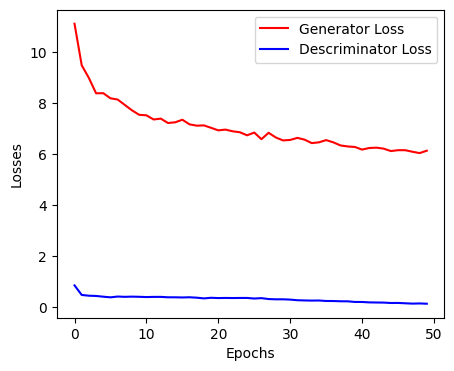

In [24]:
plt.figure(figsize=(5, 4), dpi=100)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
plt.plot(gan.desc_stats.losses, 'b', label='Descriminator Loss')
plt.legend()
plt.show()

А также на то, как генератор работает на тренировочных данных.

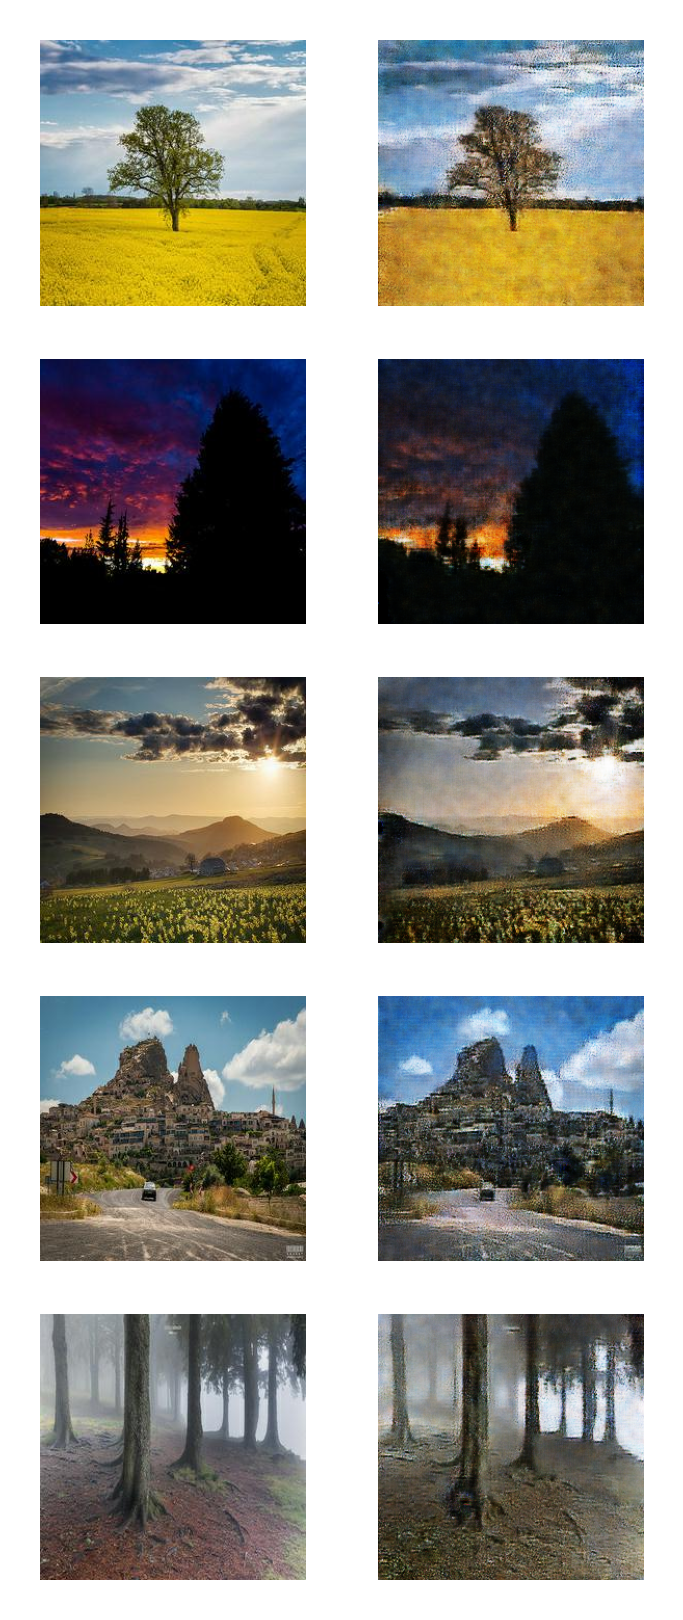

In [25]:
_, ax = plt.subplots(5, 2, figsize=(2, 5), dpi=400)
for i in range(5):
    _, photo_img = next(iter(img_dl))
    pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
    photo_img = unnorm(photo_img)
    pred_monet = unnorm(pred_monet)
    
    ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Раздел 2. Проектирование интерфейса

Интерфейс взаимодействия с ботом будем делать на основе телеграм бота. Для этого используется система http запросов на сервера телеграма с соотвествующим токеном бота (у каждого бота он уникален). Для работы бота я создал 3 пайтоновских файла, разберемся с каждым из них.

- `bot.py` - файл, который будем запускать для работы боты, который соотвественно импортирует все остальные файлы; в нем реализовано получение и отправка запросов на сервера телеграма с помощью библиотеки `requests`

In [ ]:
import requests, time, os
from backend import * # тут загружается и будет использоваться обученная модель

TOKEN = os.environ.get('SE-CW_TOKEN') # токен бота загружается из переменных среды
API_URL = 'https://api.telegram.org/bot' # сюда отправляются запросы для telegram bot api

# здесь реализован long-polling, т.е. запрашиваем обновления бота раз в 3 секунды
offset = -2
while True:
    # по такому запросу можно получить обновления бота
    # offset используется для того, чтобы не получать информацию о старых сообщениях
    updates = requests.get(f'{API_URL}{TOKEN}/getUpdates?offset={offset + 1}').json()

    if updates['result']:
        for result in updates['result']:
            user_id = result['message']['from']['id']
            offset = result['update_id']

            if 'photo' in result['message']:
                file_id = result['message']['photo'][-1]['file_id']
                # по такому запросу получаем информацию по файлу который отравил пользователь
                file_info = requests.get(f"{API_URL}{TOKEN}/getFile?file_id={file_id}").json()
                file_path = file_info['result']['file_path']
                # а этот запрос позволяет его скачать
                response = requests.get(f"https://api.telegram.org/file/bot{TOKEN}/{file_path}")
                with open(INPUT_PTH, "wb") as file:
                    file.write(response.content)
                generate_monet()
                with open(OUTPUT_PTH, 'rb') as photo:
                    # этот запрос позволяет отправить пользователю фотографию
                    response = requests.post(f'{API_URL}{TOKEN}/sendPhoto',
                                             data={'chat_id': user_id}, files={'photo': photo})
            else:
                # этим запросом отправляем текстовое сообщение пользователю
                response = requests.get(url=f'{API_URL}{TOKEN}/sendMessage',
                                        params={
                                            'chat_id': user_id,
                                            'text': 'Боту можно отправлять только изображения!'
                                        })

    time.sleep(3)

- `backend.py` - часть программы, в которой работаем с ранее обученной моделью

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

from arch import Generator as gen

# тут будем хранить полученное и сгенерированное изображения
INPUT_PTH = 'bot_tempfiles/input.jpg'
OUTPUT_PTH = 'bot_tempfiles/output.jpg'

# так как архитектура бота работает с изображниями 256 на 256
# а также диапазоном в каналах от -1 до 1
# то таким преобразованием подготавливаем фотографию для обработки
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# подгружаем модель
model = gen(3, 3)
model.load_state_dict(torch.load('model.pth'))
model.eval()

# эта функция вызывается в bot.py, она работает с изображением по пути INPUT_PTH
# и выгружает результат в OUTPUT_PTH
def generate_monet():
    image = Image.open(INPUT_PTH)
    # а вот эта трансформация вернет изображение к исходному формату
    bw_transform = transforms.Compose([
        transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]),
        transforms.ToPILImage(),
        transforms.Resize((image.size[1], image.size[0]))
    ])
    tensor = transform(image)
    # это добавляет измерение батча
    tensor = tensor.unsqueeze(0)
    image = model(tensor).detach()
    image = bw_transform(image[0])
    image.save(OUTPUT_PTH)

- `arch.py` - хранит в себе архитектуру генератора, чтобы не хранить её в `model.pth`

In [ ]:
import torch.nn as nn

def Upsample(in_ch, out_ch, use_dropout=True, dropout_ratio=0.5):
    if use_dropout:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.Dropout(dropout_ratio),
            nn.GELU()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.GELU()
        )

def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True):
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)

    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()

    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)

    return nn.Sequential(
        conv,
        norm,
        actv
    )

class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Convlayer(in_features, in_features, 3, 1, False, use_pad=False))
        layers.append(nn.Dropout(dropout_ratio))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(in_features))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

class Generator(nn.Module):
    def __init__(self, in_ch, out_ch, num_res_blocks=6):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))
        model.append(Convlayer(in_ch, 64, 7, 1, False, True, False))
        model.append(Convlayer(64, 128, 3, 2, False))
        model.append(Convlayer(128, 256, 3, 2, False))
        for _ in range(num_res_blocks):
            model.append(Resblock(256))
        model.append(Upsample(256, 128))
        model.append(Upsample(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)